In [14]:
import pandas as pd  # For data handling
import re  # For regular expressions

# Load the CSV file
df = pd.read_csv('app_reviews.csv')

# Check the first few rows to understand the structure
print(df.head())

# Assuming the reviews are in a column named 'Reviews'
reviews = df['Reviews'].dropna()

# Function to clean the text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.lower()

# Apply the cleaning function to all reviews
df['cleaned_reviews'] = reviews.apply(clean_text)


                                             Reviews
0  This is the second time purchasing a Fitbit. I...
1  I had three issues after I set up a new Inspir...
2  Just 2 years and 2 months of owning my fitbit ...
3  After having 2 Fitbits changed under warranty ...
4  Versa 4 stopped working. Staff not trained, no...


In [15]:
import spacy  # For NER and POS tagging

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to extract nouns and adjectives
def extract_nouns_adjectives(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]

# Apply the function to cleaned reviews
df['nouns_adjectives'] = df['cleaned_reviews'].apply(extract_nouns_adjectives)


In [18]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

# Download the vader_lexicon
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to reviews
df['sentiment'] = df['cleaned_reviews'].apply(lambda x: sia.polarity_scores(x))

# Extract all words and their sentiment scores
all_words = [word for words in df['nouns_adjectives'] for word in words]
word_freq = Counter(all_words)
word_sentiments = {word: sia.polarity_scores(word)['compound'] for word in word_freq}

# Separate positive and negative words
positive_words = {word: score for word, score in word_sentiments.items() if score > 0.5}
negative_words = {word: score for word, score in word_sentiments.items() if score < -0.5}

# Frequency analysis of positive and negative words
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [19]:
# Filter positive reviews
positive_reviews = df[df['sentiment'].apply(lambda x: x['compound']) > 0.5]

# Extract nouns and adjectives from positive reviews
positive_reviews['nouns_adjectives'] = positive_reviews['cleaned_reviews'].apply(extract_nouns_adjectives)

# Flatten the list of nouns and adjectives from positive reviews and count frequency
positive_features = [word for words in positive_reviews['nouns_adjectives'] for word in words]
positive_feature_freq = Counter(positive_features)

# Display the most common positive and negative words
print("Top Positive Words:", sorted(positive_words.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top Negative Words:", sorted(negative_words.items(), key=lambda x: x[1])[:10])
print("Most Common Features in Positive Reviews:", positive_feature_freq.most_common(10))

# Filter negative reviews
negative_reviews = df[df['sentiment'].apply(lambda x: x['compound']) < -0.5]

# Extract nouns and adjectives from negative reviews
negative_reviews['nouns_adjectives'] = negative_reviews['cleaned_reviews'].apply(extract_nouns_adjectives)

# Flatten the list of nouns and adjectives from negative reviews and count frequency
negative_features = [word for words in negative_reviews['nouns_adjectives'] for word in words]
negative_feature_freq = Counter(negative_features)

# Display the most common negative features
print("Most Common Features in Negative Reviews:", negative_feature_freq.most_common(10))


<ipython-input-19-c1369d3885a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['nouns_adjectives'] = positive_reviews['cleaned_reviews'].apply(extract_nouns_adjectives)


Top Positive Words: [('best', 0.6369), ('love', 0.6369), ('great', 0.6249), ('superb', 0.6249), ('outstanding', 0.6124), ('super', 0.5994), ('beautiful', 0.5994), ('joy', 0.5859), ('lovely', 0.5859), ('successful', 0.5859)]
Top Negative Words: [('murder', -0.6908), ('hell', -0.6808), ('catastrophe', -0.6597), ('dead', -0.6486), ('worst', -0.6249), ('dismal', -0.6124), ('infuriated', -0.6124), ('racist', -0.6124), ('irate', -0.5994), ('death', -0.5994)]
Most Common Features in Positive Reviews: [('app', 148), ('fitbit', 88), ('free', 66), ('great', 63), ('years', 58), ('strava', 45), ('time', 44), ('food', 38), ('calories', 38), ('fitness', 34)]
Most Common Features in Negative Reviews: [('fitbit', 213), ('customer', 105), ('service', 87), ('app', 78), ('watch', 75), ('months', 51), ('charge', 51), ('years', 50), ('replacement', 38), ('company', 38)]


<ipython-input-19-c1369d3885a3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['nouns_adjectives'] = negative_reviews['cleaned_reviews'].apply(extract_nouns_adjectives)


                                             Reviews fitness_goals
0  This is the second time purchasing a Fitbit. I...            []
1  I had three issues after I set up a new Inspir...            []
2  Just 2 years and 2 months of owning my fitbit ...            []
3  After having 2 Fitbits changed under warranty ...            []
4  Versa 4 stopped working. Staff not trained, no...            []
5  I have a  Versa Fitbit purchased 2021 - it is ...            []
6  I had a Fitbit Inspire 2 which you could only ...            []
7  Had a Fitbit sense for 2 years went swimming 3...            []
8  Do not recomend it! Disappointing Product and ...            []
9  Fitbit is definitely not worth the money. Buy ...            []


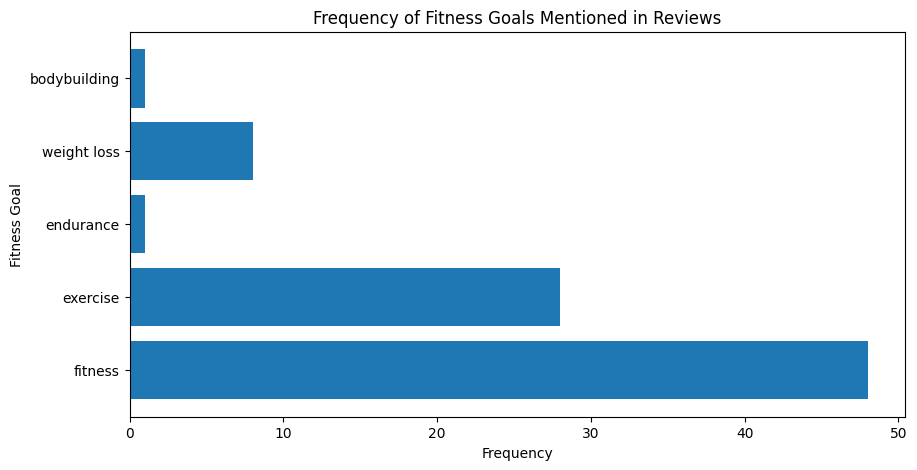

In [20]:
# Define fitness-related keywords
fitness_keywords = ['weight loss', 'muscle gain', 'endurance', 'stamina', 'strength', 'fitness', 'toning', 'bodybuilding', 'cardio', 'exercise']

# Function to extract fitness goals
def extract_fitness_goals(text, keywords):
    goals = []
    for keyword in keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', text):
            goals.append(keyword)
    return goals

# Apply the function to reviews
df['fitness_goals'] = df['cleaned_reviews'].apply(lambda x: extract_fitness_goals(x, fitness_keywords))

# Display reviews with fitness goals
print(df[['Reviews', 'fitness_goals']].head(10))

# To visualize the frequency of different fitness goals
all_goals = [goal for goals in df['fitness_goals'] for goal in goals]
goal_freq = Counter(all_goals)

# Plot the frequency of fitness goals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
goals, frequencies = zip(*goal_freq.items())
plt.barh(goals, frequencies)
plt.xlabel('Frequency')
plt.ylabel('Fitness Goal')
plt.title('Frequency of Fitness Goals Mentioned in Reviews')
plt.show()

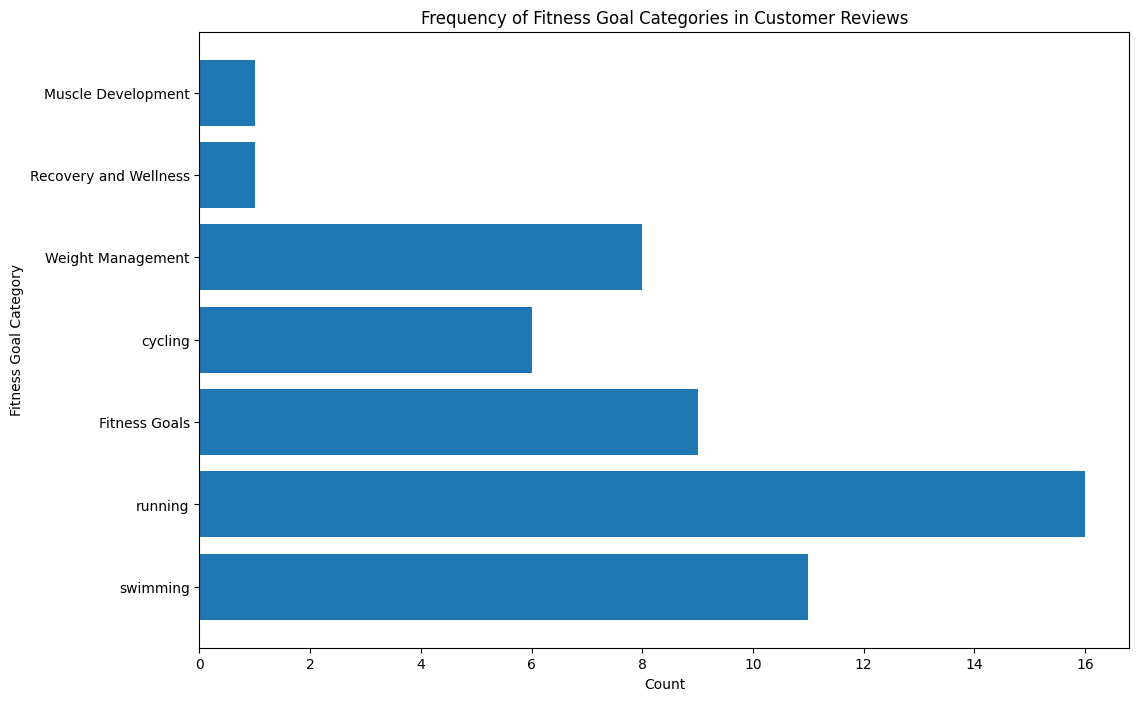

In [21]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# Load the data
df = pd.read_csv('app_reviews.csv')

# Clean the text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.lower()

df['cleaned_reviews'] = df['Reviews'].dropna().apply(clean_text)

# Detailed list of fitness-related keywords
detailed_keywords = [
    'weight loss', 'fat burning', 'body transformation', 'body composition',
    'muscle gain', 'toning', 'bodybuilding', 'strength training', 'muscle definition',
    'endurance', 'stamina', 'conditioning', 'performance', 'speed', 'agility',
    'flexibility', 'mobility', 'cardio', 'hiit', 'crossfit', 'resistance training',
    'aerobic fitness', 'anaerobic fitness', 'post-workout recovery', 'injury prevention',
    'rehabilitation', 'stress relief', 'overall health', 'running', 'cycling',
    'swimming', 'hiking', 'personal training', 'gym workouts', 'home workouts',
    'low-impact exercises', 'high-impact exercises'
]

# Concise categories
category_keywords = {
    'Weight Management': ['weight loss', 'fat burning', 'body transformation', 'body composition'],
    'Muscle Development': ['muscle gain', 'toning', 'bodybuilding', 'strength training', 'muscle definition'],
    'Fitness Goals': ['endurance', 'stamina', 'conditioning', 'performance', 'speed', 'agility', 'flexibility', 'mobility'],
    'Exercise Types': ['cardio', 'hiit', 'crossfit', 'resistance training', 'aerobic fitness', 'anaerobic fitness'],
    'Recovery and Wellness': ['post-workout recovery', 'injury prevention', 'rehabilitation', 'stress relief', 'overall health'],
    'running': ['running'],
    'cycling':['cycling'],
    'swimming':['swimming'],
    'Training Approaches': ['personal training', 'gym workouts', 'home workouts', 'low-impact exercises', 'high-impact exercises']
}

# Function to extract fitness goals
def extract_fitness_goals(text, keywords):
    goals = []
    for keyword in keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', text):
            goals.append(keyword)
    return goals

# Extract fitness goals for each review
df['fitness_goals'] = df['cleaned_reviews'].apply(lambda x: extract_fitness_goals(x, detailed_keywords))

# Map detailed goals to concise categories
def map_goals_to_categories(goals, category_keywords):
    categories = defaultdict(int)
    for goal in goals:
        for category, keywords in category_keywords.items():
            if goal in keywords:
                categories[category] += 1
    return categories

# Apply mapping to each review
df['goal_categories'] = df['fitness_goals'].apply(lambda x: map_goals_to_categories(x, category_keywords))

# Aggregate counts for each category
total_counts = Counter()
for categories in df['goal_categories']:
    total_counts.update(categories)


# Plot the results
plt.figure(figsize=(12, 8))
categories, counts = zip(*total_counts.items())
plt.barh(categories, counts)
plt.xlabel('Count')
plt.ylabel('Fitness Goal Category')
plt.title('Frequency of Fitness Goal Categories in Customer Reviews')
plt.show()

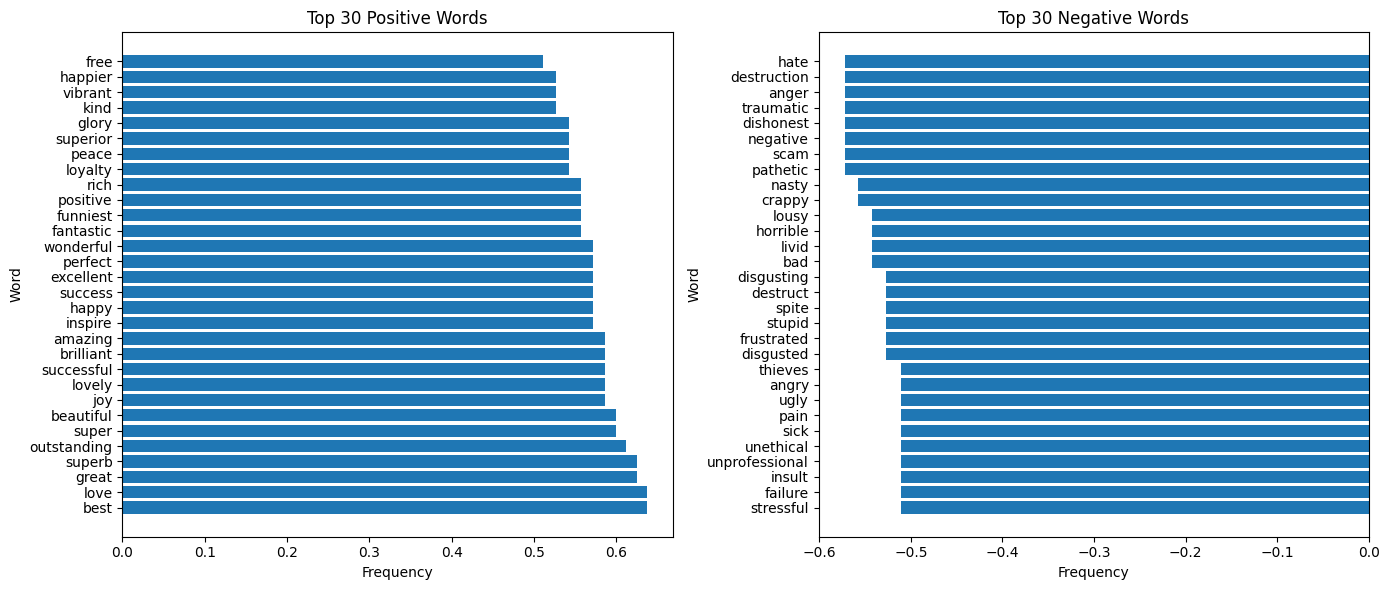

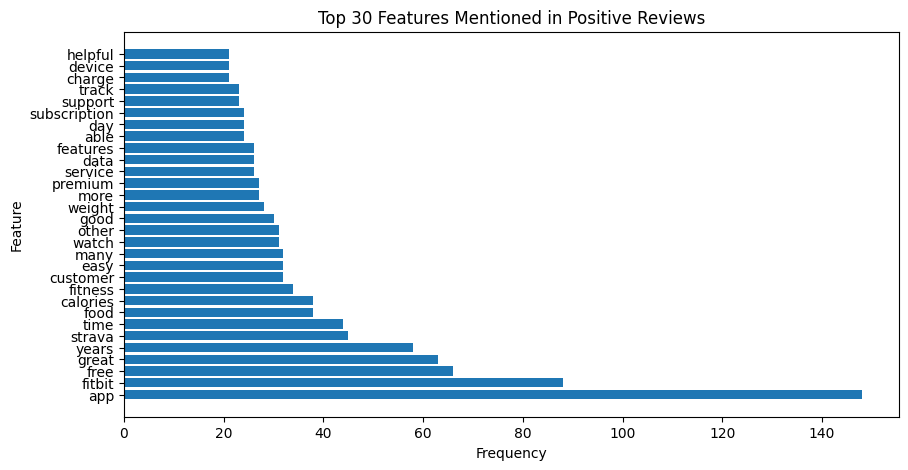

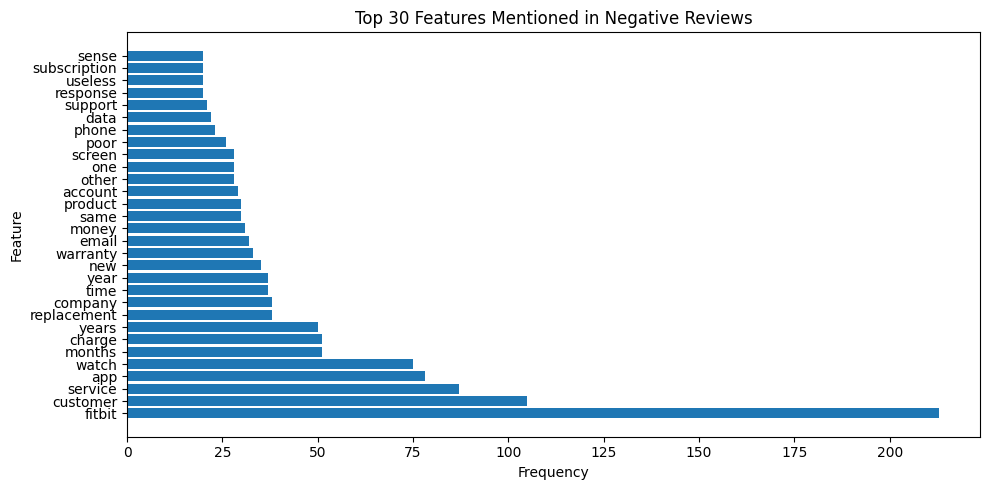

In [22]:
import matplotlib.pyplot as plt

# Plot positive and negative words
plt.figure(figsize=(14, 6))

# Plot positive words
plt.subplot(1, 2, 1)
positive_common = positive_word_freq.most_common(30)
positive_words_list, positive_frequencies = zip(*positive_common)
plt.barh(positive_words_list, positive_frequencies)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 30 Positive Words')

# Plot negative words
plt.subplot(1, 2, 2)
negative_common = negative_word_freq.most_common(30)
negative_words_list, negative_frequencies = zip(*negative_common)
plt.barh(negative_words_list, negative_frequencies)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 30 Negative Words')

plt.tight_layout()
plt.show()

# Plot features from positive reviews
plt.figure(figsize=(10, 5))
feature_common = positive_feature_freq.most_common(30)
features, feature_frequencies = zip(*feature_common)

plt.barh(features, feature_frequencies)
plt.xlabel('Frequency')
plt.ylabel('Feature')
plt.title('Top 30 Features Mentioned in Positive Reviews')
plt.show()

# Plot features from negative reviews
plt.figure(figsize=(10, 5))
feature_common = negative_feature_freq.most_common(30)
features, feature_frequencies = zip(*feature_common)

plt.barh(features, feature_frequencies)
plt.xlabel('Frequency')
plt.ylabel('Feature')
plt.title('Top 30 Features Mentioned in Negative Reviews')

plt.tight_layout()
plt.show()